In [25]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=False)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

In [46]:
# 상수 정의
deg_to_rad = np.pi/180.0
rad_to_deg = 180.0/np.pi

# R_out : external collimator 반지름 (mm)
# R_in : internal collimator 반지름 (mm)
# R_d : 검출기 반경 (mm) . 현재는 R_in/2.0 으로 설정.

R_out = 95.0
R_in = 25.0

R_d = R_out/2.0
# detector pixel assignment
# Number of bins in x and y axis
Nbins = 1000
y0 = np.linspace(-1.0*R_d, R_d, Nbins)
z0 = np.linspace(-1.0*R_d, R_d, Nbins)
y1, z1 = 0.5*(y0[1:]+y0[:-1]), 0.5*(z0[1:]+z0[:-1])
dy, dz = y0[1]-y0[0], z0[1]-z0[0]

YY, ZZ = np.meshgrid(y1, z1)
RR = np.sqrt(YY**2+ZZ**2)

# generate slit in degree

slit_open_deg = 5.0
slit_period_deg = 15.0
slit_angle_start = -77.5


def get_closed_from_slit_open(open_deg):
    d0=-90.0
    d1=90.0
    result = []
    for sl in open_deg:
        result.append((d0, sl[0]))
        d0 = sl[1]
    result.append((d0, 90.0))
    return result
        
    
    

def plot_hemispherical_collimoator(R1, slits1, R2=None, slits2=None, view_ele=30.0, view_azim=45.0):
    th0 = np.linspace(0.0, np.pi, 100)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection='3d')
    ax.view_init(view_ele, view_azim)
    cslits1 = get_closed_from_slit_open(slits1)
    cslits2 = get_closed_from_slit_open(slits2)
    for sl1 in cslits1:
        ph0 = np.linspace(sl1[0]*deg_to_rad, sl1[1]*deg_to_rad, 100)
        Theta, Phi = np.meshgrid(th0, ph0)
        X1 = R1 * np.sin(Theta) * np.cos(Phi)
        Y1 = R1 * np.sin(Theta) * np.sin(Phi)
        Z1 = R1 * np.cos(Theta)
        
        plot = ax.plot_surface(
            X1, Y1, Z1, rstride=1, cstride=1, color="b",
            linewidth=0, antialiased=False, alpha=0.3)
        
    for sl2 in cslits2:
        ph0 = np.linspace(sl2[0]*deg_to_rad, sl2[1]*deg_to_rad, 100)
        Theta, Phi = np.meshgrid(th0, ph0)
        X2 = R2 * np.sin(Theta) * np.cos(Phi)
        Y2 = R2 * np.sin(Theta) * np.sin(Phi)
        Z2 = R2 * np.cos(Theta)
        
        plot = ax.plot_surface(
            X2, Y2, Z2, rstride=1, cstride=1, color="r",
            linewidth=0, antialiased=False, alpha=0.4)
    
    world_limits = ax.get_w_lims()
    ax.set_box_aspect((world_limits[1]-world_limits[0],world_limits[3]-world_limits[2],world_limits[5]-world_limits[4]))
    

def get_solution2(a,b,c):
    """
    $ax^2+bx+c=0$ 의 2차방정식의 해를 return 한다.
    
    $D=\sqrt{b^2-4ac}$ 하 할 때,
    
    answer :
    
    (-b+D)/2, (-b-D)/2a
    
    """
    D=np.sqrt(b**2-4*a*c)
    
    return ((-b+D)/(2*a), (-b-D)/(2*a))


def cartesian_to_spherical2(x, y, z):
    """
    args
    ----
    x, y, z
    
    return sperical coordinate from given cartesian coordinate (x, y, z) 
    
    return
    ---
    (r, theta [deg], phi [deg])
    
    Warning : if x=y=z=0.0, return (0.0, 0.0, 0.0)
    """
    r=np.sqrt(x**2+y**2+z**2)
    theta = 0.0
    phi = 0.0
    if r==0.0:
        return (0.0, 0.0, 0.0)
    if z==0.0:
        theta = np.pi/2.0
    else :
        theta = np.arccos(z/r)
    if x == 0.0:
        phi = 0.0
    else :
        phi = np.arctan2(y, x)
    
    return (r, theta*rad_to_deg, phi*rad_to_deg)

def cartesian_to_spherical(x, y, z):
    """
    args
    ----
    x, y, z
    
    return sperical coordinate from given cartesian coordinate (x, y, z) 
    
    return
    ---
    (r, theta [deg], phi [deg])
    
    Warning : if x=y=z=0.0, return (0.0, 0.0, 0.0)
    """
    theta = np.zeros(x.shape)
    phi = np.zeros(x.shape)
    r=np.sqrt(x**2+y**2+z**2)
    r0ind=np.where(r==0.0)
    rind = np.where(r>0.0)
    x0ind = np.where(x==0.0)
    #xind = np.where(x!=0.0)
    theta[rind] = np.arccos(z[rind]/r[rind])
    phi= np.arctan2(y, x)
    
    return (r, theta*rad_to_deg, phi*rad_to_deg)


def spherical_to_cartesian(r, theta, phi):
    """
    args
    ----
    r, theta [deg], phi[deg]
    
    return sperical coordinate from given cartesian coordinate (x, y, z) 
    
    return
    ---
    (x, y, z)
    """
    th, ph = theta*deg_to_rad, phi*deg_to_rad
    
    return (r*np.sin(th)*np.cos(ph), r*np.sin(th)*np.sin(ph), r*np.cos(th))
    
    

slit_open_list_rad = []
slit_open_list_deg = []
for t_ang in np.arange(slit_angle_start, 90.0-slit_open_deg, slit_period_deg):
    slit_open_list_rad.append((t_ang*deg_to_rad, (t_ang+slit_open_deg)*deg_to_rad))
    slit_open_list_deg.append((t_ang, t_ang+slit_open_deg))

def is_open(angle):
    """
    angle : angle in degree
    """
    result = False
    angrad = angle*deg_to_rad
    
    for angs in slit_open_list_rad:
        if angrad < angs[0]:
            pass
        elif (angrad >= angs[0]) and (angrad <= angs[1]):
            result = True
            break
        
    return result

aa=np.arange(-90, 90.005, 0.01)
ex_angle_mask =np.fromiter((is_open(ai) for ai in aa), aa.dtype)
print(ex_angle_mask)


def generate_solid_angle(source_position):
    xs, ys, zs = source_position[0], source_position[1], source_position[2]
    n_area = dy * dz
    M_cos = xs/np.sqrt((xs)**2+(ys-YY)**2+(zs-ZZ)**2)
    
    return M_cos

def get_position_on_Rsphere_cartesian(source_position, Rsp, Y, Z):
    """
    hemisphere의 반경을 R 이라 하자. source가 (x, y, z)에 위치할 때 source에서 
    각 pixel의 중앙으로 직선을 그렸을 때 반경 R 인 구와 만나는 점의 3차원 좌표
    를 return 한다.
    
    args
    -------
    source_position : list/tuple/array with 3 elements in mm 
    d_pixel : 검출기 중앙에서 각 pixel 까지의 거리를 나타내는 nxn array
    Rsp : spherical collimator 반경
    Y : 각 pixel의 y값을 나타내는 nxn array
    Z : 각 pixel의 z값을 나타내는 nxn array
    
    return
    ------
    (XR, YR, ZR)
       
    """
    
    xs, ys, zs = source_position[0], source_position[1], source_position[2]
    
    A=xs**2+(ys-Y)**2+(zs-Z)**2
    B=2.0*(Y*(ys-Y)+Z*(zs-Z))
    #C=Y**2+Z**2-d_pixel**2
    C=Y**2+Z**2-Rsp**2
    
    t1, t2=get_solution2(A, B, C)
    
    XR=xs*t1
    YR=(ys-Y)*t1+Y
    ZR=(zs-Z)*t1+Z
    
    return (XR, YR, ZR)

def get_position_on_Rsphere_spherical(source_position, Rph, Y, Z):
    XR, YR, ZR = get_position_on_Rsphere_cartesian(source_position, Rph, Y, Z)
    #ex_angle_mask =np.fromiter((is_open(ai) for ai in aa), aa.dtype)
    M_R, M_theta, M_phi = cartesian_to_spherical(XR, YR, ZR)
    print(M_R.max(), M_R.min(),M_theta.min(), M_theta.max(), M_phi.min(), M_phi.max())
    return M_theta, M_phi


def calc_valid_phi(source_position, d_pixel, Y, Z):
    Mth, Mph = get_position_on_Rsphere_spherical(source_position, d_pixel, Y, Z)
    M1=np.fromiter((is_open(mi) for mi in Mph.flatten()), Mph.dtype)
    return M1.reshape(Mph.shape)



[0. 0. 0. ... 0. 0. 0.]


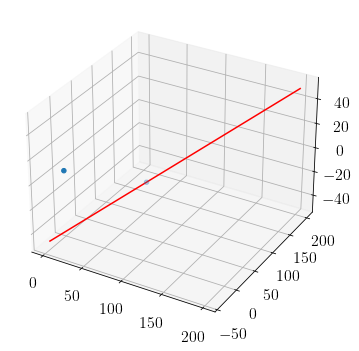

In [71]:
#slit_open_list_deg
xx, yy, zz=get_position_on_Rsphere_cartesian([200, 200, 50], R_out, YY, ZZ)
x1, y1, z1 = xx.flatten(), yy.flatten(), zz.flatten()
r1=np.sqrt(x1**2+y1**2+z1**2)
r1.min(), r1.max()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot([200, 0.0], [200, YY[0,98]], [50, ZZ[0,98]], 'r-')
ax.scatter([0.0, xx[0,98]], [0.0,yy[0, 98]], [0.0,zz[0,98]])

In [72]:
M_theta, M_phi = get_position_on_Rsphere_spherical([450., 450., 0], R_out, YY, ZZ)

95.00000000000004 94.99999999999996 62.456105901971924 117.54389409802808 26.274361315096396 66.64072166114714


In [88]:
MK = calc_valid_phi([R_out*10.*np.cos(25.0*deg_to_rad), R_out*10.*np.sin(25.0*deg_to_rad), 0], R_out, YY, ZZ)

95.00000000000004 94.99999999999996 61.90905366361865 118.09094633638138 -2.2006116488340393 53.929905447037925


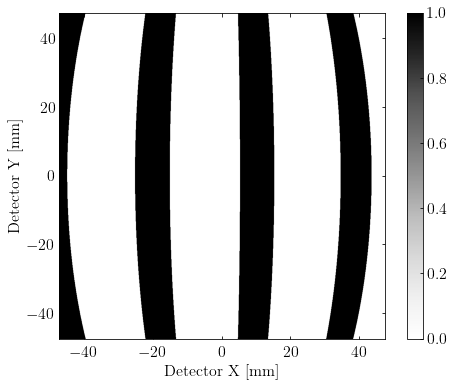

In [96]:
plt.imshow(MK, origin='lower', extent=[-R_d, R_d, -R_d, R_d], cmap="Greys")
#plt.colormap("greys")
plt.colorbar()
plt.xlabel("Detector X [mm]")
plt.ylabel("Detector Y [mm]")
plt.savefig("test1.pdf")

In [66]:
MM.flatten()

array([1., 1., 1., ..., 1., 1., 1.])

In [31]:
cartesian_to_spherical(1.0, 1.0, 1.0)

(1.7320508075688772, 54.735610317245346, 45.0)

In [34]:
spherical_to_cartesian(1, 90., 45.0)

(0.7071067811865476, 0.7071067811865476, 6.123233995736766e-17)

In [63]:
np.arctan2(1.0, 0.0)*180.0/np.pi

90.0

In [80]:
YY.min()

-12.373737373737374

In [81]:
YY.max()

12.373737373737374

In [82]:
ZZ.min()

-12.373737373737374

In [83]:
ZZ.max()

12.373737373737374

In [83]:
slit_open_list_deg

[(-77.5, -72.5),
 (-62.5, -57.5),
 (-47.5, -42.5),
 (-32.5, -27.5),
 (-17.5, -12.5),
 (-2.5, 2.5),
 (12.5, 17.5),
 (27.5, 32.5),
 (42.5, 47.5),
 (57.5, 62.5),
 (72.5, 77.5)]

In [21]:
is_open(10.0)

True

In [29]:
np.sqrt(350.0**2+(95.0/2.0)**2)

353.20850782505227

In [32]:
np.arccos((353.21**2-303.21**2)/(2.0*95.0/2.0*350.0))*rad_to_deg

9.21379421263367

In [74]:
tt=np.arctan2(4,  1.)

In [75]:
(np.pi/2-(np.pi-2*tt))*rad_to_deg

61.92751306414706

In [76]:
tt*rad_to_deg

75.96375653207353

In [77]:
get_solution2(1., -2.0*np.cos(tt), -3)

(1.9914848894267452, -1.5064136393540795)

In [79]:
yy=np.sqrt(17.)-1.99149

In [80]:
yy

2.131615625617661

In [82]:
np.arccos((2**2+4**2-2.1316**2)/2.0/2.0/4.0)*rad_to_deg

14.979672452162394

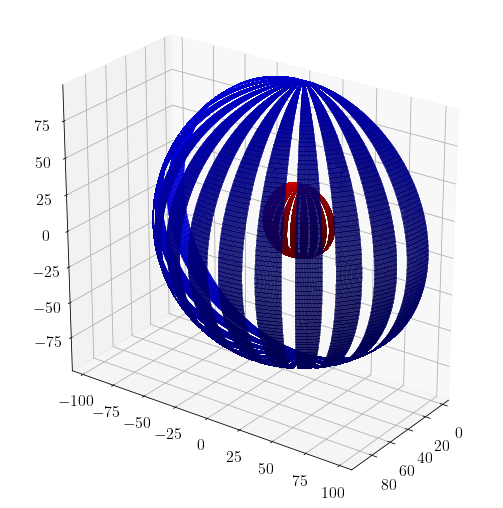

In [53]:
plot_hemispherical_collimoator(95, slit_open_list_deg, 25, slit_open_list_deg, 25., 36.)
plt.savefig("test2.pdf")

In [50]:
plt.savefig("test2.pdf")

<Figure size 864x648 with 0 Axes>

In [30]:
slit_open_list_deg

[(-77.5, -72.5),
 (-62.5, -57.5),
 (-47.5, -42.5),
 (-32.5, -27.5),
 (-17.5, -12.5),
 (-2.5, 2.5),
 (12.5, 17.5),
 (27.5, 32.5),
 (42.5, 47.5),
 (57.5, 62.5),
 (72.5, 77.5)]

In [34]:
slit_closed_liset_deg = get_closed_from_slit_open(slit_open_list_deg)

In [35]:
slit_closed_liset_deg

[(-90.0, -77.5),
 (-72.5, -62.5),
 (-57.5, -47.5),
 (-42.5, -32.5),
 (-27.5, -17.5),
 (-12.5, -2.5),
 (2.5, 12.5),
 (17.5, 27.5),
 (32.5, 42.5),
 (47.5, 57.5),
 (62.5, 72.5),
 (77.5, 90.0)]

In [52]:
plt.gcf()

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>